## Assignment: Capstone Project - The Battle of Neighborhoods

### Predicting a place to open a clothing store in Toronto neighbourhood

### Introduction

A person is trying to open a clothing store in neighbourhood of Toronto and is looking in for some places where it would be good to open. Before opening a clothing store, it is better to know about the places where there is a demand for such store. It is also good to know about other clothing stores which are already present in nearby places and about their ratings. When we identify the places which does not have much of clothing stores,it would be good to choose that place.

 - The Data required will be collected from Wikipedia.  https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M,
 - The data consists of postal codes and the respective places. 
 - Some cleaning process will be done in order to make the data clear and usable.
    - Ignore cells with a borough that is Not assigned
    - Combining rows which has more than one neighborhood one postal code area
    - Getting the latitude and Longitude values and assigning it to a new columns in Dataframe
 - Using Foursquare API, the neighborhoods and venues in the neighborhoods will be discovered. Then the number of clothing store in each venue will be taken into account. 
 - Using Clustering algorithms, the clusters will be formed in the neighborhoods.
 - Finally, the folium library is used to visualize the clusters. Based on the clusters formed, prediction can be done as where the demand is high to open a clothing store.

## 1. Download and Explore Neigborhood Dataset

#### Install libraries 

In [2]:
#install libraries 
!pip install geopy    
!pip install folium   
!pip install geocoder

     |████████████████████████████████| 102kB 7.9MB/s ta 0:00:011
     |████████████████████████████████| 102kB 8.3MB/s ta 0:00:011


#### Import libraries 

In [3]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

from geopy.geocoders import Nominatim
import geocoder # to get coordinates

import folium 

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt # for graphical usage 
import json # library to handle JSON files

from folium import plugins
from folium.plugins import HeatMap

import scipy.cluster.hierarchy as shc

from sklearn.cluster import AgglomerativeClustering

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


### Scraping data and transforming data to dataframe which will consist of three columns: PostalCode, Borough, and Neighborhood

In [4]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(source.text, 'lxml')

data = []
columns = []
table = soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
    
    if (index == 0):
        columns = section
    else:
        data.append(section)

#convert list into Pandas DataFrame
canada_df = pd.DataFrame(data = data,columns = columns)
canada_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Ignore cells with a borough that is Not assigned

In [5]:
canada_df1 = canada_df[canada_df['Borough'] != 'Not assigned']
canada_df1.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### combining rows which has more than one neighborhood one postal code area

In [6]:
# More than one neighborhood can exist in one postal code area, combined these into one row with the neighborhoods separated with a comma

canada_df2 = canada_df1.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
canada_df2.reset_index(inplace=True)

# Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough
canada_df2['Neighbourhood'] = np.where(canada_df2['Neighbourhood'] == 'Not assigned',canada_df2['Borough'], canada_df2['Neighbourhood'])

canada_df2.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### .shape method to print the number of rows of dataframe

In [7]:
canada_df2.shape

(103, 3)

### Importing the csv file conatining the latitudes and longitudes for various neighbourhoods in Canada

In [8]:
Geodf = pd.read_csv("http://cocl.us/Geospatial_data")
Geodf.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merging the two tables for getting the Latitudes and Longitudes for various neighbourhoods in Canada

In [9]:
canada_df2 = pd.merge(canada_df2,Geodf,on='Postal Code')
canada_df2.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Getting all the rows from the data frame which contains Toronto in their Borough.

In [10]:
canada_df3 = canada_df2[canada_df2['Borough'].str.contains('Toronto',regex=False)]
canada_df3.shape


(39, 5)

In [11]:
canada_df3.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True) 
canada_df3.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


### Use geopy library to get the latitude and longitude values of Toronto.

In [12]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Create a map of Toronto with neighborhoods superimposed on top.

In [13]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(canada_df3['Latitude'], canada_df3['Longitude'], canada_df3['Borough'], canada_df3['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## 2. Load Venues and Analyze Neighborhoods in Toronoto

### Define Foursquare Credentials and Version

In [14]:
CLIENT_ID = '5W2RVUK55RGWP0YS35ZKBW3GGF3UJIRGKUQDJP14HPOZ3LMI' # your Foursquare ID
CLIENT_SECRET = '5OAW2TL0SZKVZ3BPELS2T35NFUX1GLCWY0LTS2GDVJ2CFDCE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5W2RVUK55RGWP0YS35ZKBW3GGF3UJIRGKUQDJP14HPOZ3LMI
CLIENT_SECRET:5OAW2TL0SZKVZ3BPELS2T35NFUX1GLCWY0LTS2GDVJ2CFDCE


In [15]:
canada_df3.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [16]:
LIMIT = 100

def getNeighborhoodVenues( latitude, longitude,neighborhood, radius=1000 ):
    venues = []
    for lat, long, neighborhood in zip(latitude, longitude ,neighborhood):

        # create the API request URL
        url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            long,
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

 # return only relevant information for each nearby venue
        for venue in results:
            venues.append((
                neighborhood,
                lat, 
                long, 
                venue['venue']['name'], 
                venue['venue']['id'], 
                venue['venue']['location']['lat'], 
                venue['venue']['location']['lng'],  
                venue['venue']['location']['distance'],  
                venue['venue']['categories'][0]['name']))
    
    # convert the venues list into a DataFrame
    venues = pd.DataFrame(venues)
    # define the column names
    venues.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueId', 'VenueLatitude', 'VenueLongitude','VenueDistance','VenueCategory']
            
    return venues 

neighborhood_venues = getNeighborhoodVenues (canada_df3['Latitude'], canada_df3['Longitude'], canada_df3['Neighborhood'] )

print('There are {} unique venue categories. Some of them are as below:'.format(len(neighborhood_venues['VenueCategory'].unique())))
neighborhood_venues.head()

There are 271 unique venue categories. Some of them are as below:


,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,54ea41ad498e9a11e9e13308,43.653447,-79.362017,143,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,53b8466a498e83df908c3f21,43.653559,-79.361809,122,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,574c229e498ebb5c6b257902,43.653249,-79.358008,239,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,5612b1cc498e3dd742af0dc8,43.656369,-79.356980,376,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,4ad4c05ef964a520bff620e3,43.650244,-79.359323,459,Historic Site


In [17]:
print('Top 10 distinct venue counts are as below')
neighborhood_venues[['VenueId','VenueCategory']].drop_duplicates().groupby('VenueCategory').count()[['VenueId']].rename(columns={"VenueId": "Count"}).sort_values(by=['Count'], ascending=False)[:10]

Top 10 distinct venue counts are as below


,Count
VenueCategory,
Coffee Shop,157
Café,110
Park,66
Italian Restaurant,56
Restaurant,52
Bakery,49
Bar,46
Pizza Place,39
Sushi Restaurant,38


### Filter restaurants out of all venues

In [18]:
neighborhood_clothing_store=neighborhood_venues[neighborhood_venues['VenueCategory'] == 'Clothing Store'].shape[0]
print('Total number of clothing_store:', neighborhood_clothing_store)
neighborhood_clothing_store_names = neighborhood_venues.loc[neighborhood_venues['VenueCategory'] == 'Clothing Store']

Total number of clothing_store: 20


28 neighborhoods do not have any Clothing store


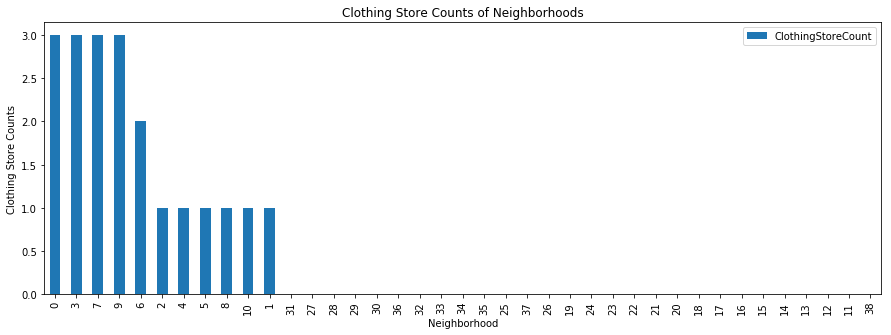

In [19]:
# get counts of restaurants in each Neighborhood
nei_clothingstore_counts =  neighborhood_clothing_store_names.groupby(['Neighborhood']).count().rename(columns={"VenueCategory": "ClothingStoreCount"})[['ClothingStoreCount']]

#find neighborhoods that does not have any restaurant 
noClothList = list(set(neighborhood_venues['Neighborhood']) - set(neighborhood_clothing_store_names['Neighborhood']))

#if exists , append neighborhoods without any restaurant to df_rest_counts
if noClothList != []:
    nei_clothingstore_counts = nei_clothingstore_counts.append (pd.DataFrame( {'Neighborhood' : noClothList  , 'ClothingStoreCount': [0] * len(noClothList) } ).set_index('Neighborhood'))

nei_clothingstore_counts.reset_index(inplace=True)


nei_clothingstore_counts= nei_clothingstore_counts.sort_values(by=['ClothingStoreCount'],ascending =False)

print('{} neighborhoods do not have any Clothing store'.format(len(noClothList)))
######
#Draw graph
nei_clothingstore_counts[['ClothingStoreCount']].plot(kind='bar',figsize=(15,5))
plt.title('Clothing Store Counts of Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Clothing Store Counts')
plt.show()

### Get the restaurant's overall rating

In [20]:
def getVenueRaitings(venues):
    
    raitings = []
    likes =[]
    for venueId in venues:

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        result = requests.get(url).json()
        try:
            rating = result['response']['venue']['rating']
            likes = result['response']['venue']['likes']['count']
        except:
            rating = None
            likes = None
        
        raitings.append((venueId, rating,likes))
 
    # convert the venues list into a DataFrame
    rating = pd.DataFrame(raitings)
    # define the column names
    rating.columns = ['VenueId', 'VenueRating','VenueLikes']

    return rating    

clothing_store_raitings = getVenueRaitings(neighborhood_clothing_store_names['VenueId'].drop_duplicates())
clothing_store_raitings.head()

,VenueId,VenueRating,VenueLikes
0,55fc4355498e02b96634274e,8.2,29.0
1,4ad4c063f964a52043f820e3,8.0,17.0
2,57eda381498ebe0e6ef40972,9.1,114.0
3,57d1e1a2498e96cce6f32217,8.2,84.0
4,4b844f98f964a520fe2d31e3,7.7,51.0


In [21]:
#merge raitings to restaurants 
neighborhood_clothing_store_names = neighborhood_clothing_store_names.merge(clothing_store_raitings)
neighborhood_clothing_store_names.head()

,Neighborhood,Latitude,Longitude,VenueName,VenueId,VenueLatitude,VenueLongitude,VenueDistance,VenueCategory,VenueRating,VenueLikes
0,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,COS,55fc4355498e02b96634274e,43.669516,-79.390390,806,Clothing Store,8.2,29.0
1,Church and Wellesley,43.665860,-79.383160,COS,55fc4355498e02b96634274e,43.669516,-79.390390,710,Clothing Store,8.2,29.0
2,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Hermes,4ad4c063f964a52043f820e3,43.669132,-79.392683,802,Clothing Store,8.0,17.0
3,"Garden District, Ryerson",43.657162,-79.378937,UNIQLO ユニクロ,57eda381498ebe0e6ef40972,43.655910,-79.380641,195,Clothing Store,9.1,114.0
4,St. James Town,43.651494,-79.375418,UNIQLO ユニクロ,57eda381498ebe0e6ef40972,43.655910,-79.380641,647,Clothing Store,9.1,114.0


In [22]:
toronto_center = [latitude, longitude]
map_clothingstore= folium.Map(location=toronto_center, zoom_start=12)
canada_df3_noclothstore = canada_df3[canada_df3['Neighborhood'].isin(noClothList)]

folium.TileLayer('cartodbpositron').add_to(map_clothingstore) 
HeatMap(neighborhood_clothing_store_names[['VenueLatitude','VenueLongitude']]).add_to(map_clothingstore)
folium.Marker(toronto_center).add_to(map_clothingstore)
folium.Circle(toronto_center, radius=2000, fill=False, color='white').add_to(map_clothingstore)
folium.Circle(toronto_center, radius=4000, fill=False, color='white').add_to(map_clothingstore)
folium.Circle(toronto_center, radius=6000, fill=False, color='white').add_to(map_clothingstore)
folium.Circle(toronto_center, radius=10000, fill=False, color='black').add_to(map_clothingstore)
for lat, lon, neig, name in zip(neighborhood_clothing_store_names['VenueLatitude'], neighborhood_clothing_store_names['VenueLongitude'], neighborhood_clothing_store_names['Neighborhood'], neighborhood_clothing_store_names['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_clothingstore)
       
raiting_lt_7 = neighborhood_clothing_store_names[neighborhood_clothing_store_names['VenueRating'] <7]
for lat, lon, neig, name in zip(raiting_lt_7['VenueLatitude'], raiting_lt_7['VenueLongitude'], raiting_lt_7['Neighborhood'], raiting_lt_7['VenueName']):
    label = folium.Popup(str(name) + ' - ' + str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_clothingstore)        
map_clothingstore

In [23]:
toronto_center = [latitude, longitude]
map_clothingstore= folium.Map(location=toronto_center, zoom_start=12)

canada_df3_noclothstore = canada_df3[canada_df3['Neighborhood'].isin(noClothList)]

folium.TileLayer('cartodbpositron').add_to(map_clothingstore) 
HeatMap(neighborhood_clothing_store_names[['VenueLatitude','VenueLongitude']]).add_to(map_clothingstore)
folium.Marker(toronto_center).add_to(map_clothingstore)
folium.Circle(toronto_center, radius=2000, fill=False, color='white').add_to(map_clothingstore)
folium.Circle(toronto_center, radius=4000, fill=False, color='white').add_to(map_clothingstore)
folium.Circle(toronto_center, radius=6000, fill=False, color='white').add_to(map_clothingstore)
folium.Circle(toronto_center, radius=10000, fill=False, color='black').add_to(map_clothingstore)

for lat, lon, neig in zip(canada_df3_noclothstore['Latitude'], canada_df3_noclothstore['Longitude'], canada_df3_noclothstore['Neighborhood']):
    label = folium.Popup(str(neig), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.7).add_to(map_clothingstore)
map_clothingstore


## 3. Cluster Neigborhoods using Agglomerative Clustering

In [24]:
# one hot encoding
onehot = pd.get_dummies(neighborhood_venues[['VenueCategory']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
onehot['Neighborhood'] = neighborhood_venues['Neighborhood']

venues_grouped = onehot.groupby(["Neighborhood"]).sum().reset_index()

print("{}  neighborhoods' venue category are shown in {} columns as below".format(venues_grouped.shape[0],venues_grouped.shape[1]-1))
venues_grouped.head()

39  neighborhoods' venue category are shown in 270 columns as below


,Neighborhood,Accessories Store,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,...,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio,Zoo
0,Berczy Park,0,0,1,0,0,0,0,2,0,...,0,0,1,0,0,0,0,0,0,0
1,"Brockton, Parkdale Village, Exhibition Place",1,0,1,0,0,0,0,1,0,...,0,0,2,0,0,0,0,0,0,0
2,"Business reply mail Processing Centre, South C...",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Bay Street,0,0,1,0,0,0,0,1,1,...,0,1,2,0,0,0,0,0,2,0


In [25]:
venues_grouped

,Neighborhood,Accessories Store,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,...,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio,Zoo
0,Berczy Park,0,0,1,0,0,0,0,2,0,...,0,0,1,0,0,0,0,0,0,0
1,"Brockton, Parkdale Village, Exhibition Place",1,0,1,0,0,0,0,1,0,...,0,0,2,0,0,0,0,0,0,0
2,"Business reply mail Processing Centre, South C...",0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Bay Street,0,0,1,0,0,0,0,1,1,...,0,1,2,0,0,0,0,0,2,0
5,Christie,0,0,1,0,0,0,0,1,0,...,0,0,2,0,0,1,0,1,0,0
6,Church and Wellesley,0,0,1,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,2,0
7,"Commerce Court, Victoria Hotel",0,0,2,0,0,0,0,2,0,...,0,0,2,0,0,0,0,0,0,0
8,Davisville,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,1,0
9,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,2,0


In [26]:
# create a new dataframe with most common venue catrgories
def return_most_common_venues(row, num_top_venues):
    row_categories = row
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

columns = ['Neighborhood','Total Number of Venues']
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues

for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Clothing store'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Clothing store'.format(ind+1))

# create a new dataframe
venues_most = pd.DataFrame(columns = columns)

for ind in range(venues_grouped.shape[0]):
    venues_most.loc[ind, 'Neighborhood'] = venues_grouped.iloc[ind].Neighborhood
    venues_most.loc[ind, 'Total Number of Venues'] = venues_grouped.iloc[ind,1:].sum()
    venues_most.iloc[ind, 2:] = return_most_common_venues(venues_grouped.iloc[ind, 1:], num_top_venues)

venues_most.head()

,Neighborhood,Total Number of Venues,1st Most Common Clothing store,2nd Most Common Clothing store,3rd Most Common Clothing store,4th Most Common Clothing store,5th Most Common Clothing store,6th Most Common Clothing store,7th Most Common Clothing store,8th Most Common Clothing store,9th Most Common Clothing store,10th Most Common Clothing store
0,Berczy Park,99,Coffee Shop,Hotel,Restaurant,Café,Park,Japanese Restaurant,Beer Bar,Gastropub,Gym,Seafood Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",99,Café,Coffee Shop,Restaurant,Bar,Furniture / Home Store,Bakery,Tibetan Restaurant,Gift Shop,Supermarket,Italian Restaurant
2,"Business reply mail Processing Centre, South C...",50,Park,Coffee Shop,Pizza Place,Brewery,Fast Food Restaurant,Burrito Place,Sushi Restaurant,Bakery,Italian Restaurant,Farmers Market
3,"CN Tower, King and Spadina, Railway Lands, Har...",14,Café,Harbor / Marina,Coffee Shop,Sculpture Garden,Garden,Dog Run,Park,Dance Studio,Track,Scenic Lookout
4,Central Bay Street,99,Coffee Shop,Sushi Restaurant,Café,Clothing Store,Park,Pizza Place,Mexican Restaurant,Breakfast Spot,Hotel,Italian Restaurant


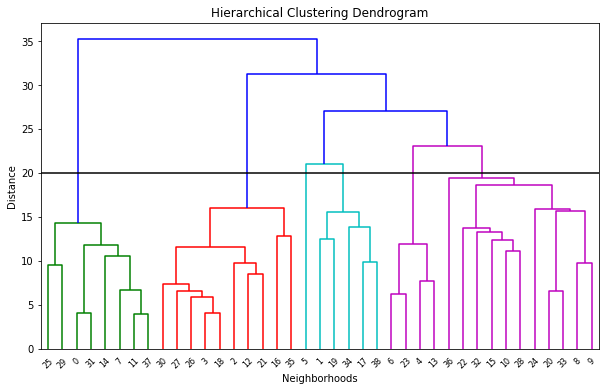

In [27]:
import scipy.cluster.hierarchy as shc

data = venues_grouped.iloc[:,3:]
plt.figure(figsize=(10, 6))   
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Distance')
plt.axhline(y=20, c='k')
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [28]:
from sklearn.cluster import AgglomerativeClustering

kclusters= 6
cluster = AgglomerativeClustering(n_clusters=kclusters, affinity='euclidean', linkage='ward')  
clusterresult = cluster.fit_predict(data)

venues_grouped['NeighborhoodCluster'] = clusterresult
venues_cluster= canada_df3.merge(venues_grouped[['Neighborhood','NeighborhoodCluster']])
venues_cluster =venues_cluster.merge(venues_most[['Neighborhood','1st Most Common Clothing store','2nd Most Common Clothing store','3rd Most Common Clothing store']])
venues_cluster.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,NeighborhoodCluster,1st Most Common Clothing store,2nd Most Common Clothing store,3rd Most Common Clothing store
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Café,Pub
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,Coffee Shop,Park,Sushi Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,Coffee Shop,Gastropub,Middle Eastern Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,Café,Coffee Shop,Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Pub,Coffee Shop,Pizza Place


In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(venues_cluster['Latitude'], venues_cluster['Longitude'], venues_cluster['Neighborhood'], venues_cluster['NeighborhoodCluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster)+ ' ' , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
folium.Marker(toronto_center).add_to(map_clusters)
folium.Circle(toronto_center, radius=2000, fill=False, color='white').add_to(map_clusters)
folium.Circle(toronto_center, radius=4000, fill=False, color='white').add_to(map_clusters)
folium.Circle(toronto_center, radius=6000, fill=False, color='white').add_to(map_clusters)
folium.Circle(toronto_center, radius=10000, fill=False, color='black').add_to(map_clusters)         
map_clusters

In [33]:
print(venues_cluster.groupby(['NeighborhoodCluster','1st Most Common Clothing store' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"}))

venues_cluster.groupby(['NeighborhoodCluster','2nd Most Common Clothing store' ]).count()[['Neighborhood']].rename(columns={"Neighborhood": "Neighborhood Count"})

                                                    Neighborhood Count
NeighborhoodCluster 1st Most Common Clothing store                    
0                   Café                                             2
                    Coffee Shop                                      8
                    Greek Restaurant                                 1
1                   Café                                             4
                    Italian Restaurant                               1
2                   Bookstore                                        1
                    Café                                             1
                    Coffee Shop                                      3
                    Indian Restaurant                                1
                    Italian Restaurant                               1
                    Park                                             2
                    Pub                                              1
3     

Neighborhood Count
NeighborhoodCluster 2nd Most Common Clothing store                    
0                   Bar                                              1
                    Café                                             3
                    Coffee Shop                                      1
                    Grocery Store                                    1
                    Italian Restaurant                               2
                    Park                                             2
                    Pizza Place                                      1
1                   Bakery                                           1
                    Bar                                              1
                    Café                                             1
                    Coffee Shop                                      1
                    Vegetarian / Vegan Restaurant                    1
2                   Coffee Shop                                      4
                    Grocery Store                                    1
                    Harbor / Marina                                  1
                    Italian Restaurant                               1
                    Park                                             2
                    Sushi Restaurant                                 1
3                   Café                                             2
                    Coffee Shop                                      1
                    Hotel                                            5
4                   Gastropub                                        1
                    Japanese Restaurant                              1
                    Park                                             1
                    Sushi Restaurant                                 1
5                   Café                                             1

## 4. Discussion

All the five clusters suffers from Clothing store. Hence it is best to open in any of the five clusters of the neighborhood.